In [1]:
import pandas as pd
pd.set_option("display.max_columns", 150)
import glob
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
#importing the data
csv_files = glob.glob('../data/trips2/*.csv')


dataframes = []


for csv_file in csv_files:
    df = pd.read_csv(csv_file, low_memory=False)
    dataframes.append(df)

citibike = pd.concat(dataframes, ignore_index=True)


citibike  = citibike.drop(columns = 'Unnamed: 0') #dropping extra column
citibike = citibike.sort_values('date').reset_index(drop = True) #sorting the values by date and resetting index.

In [3]:
#changing columns to datetime.
citibike['date'] = pd.to_datetime(citibike['date'])
citibike['year'] = pd.to_datetime(citibike['date']).dt.year
citibike['month'] = pd.to_datetime(citibike['date']).dt.month
citibike['day_of_week'] = citibike['day_of_week'].astype(str) #changing the day of week column to string.
citibike['is_snow'] = citibike['snow'] != 0
citibike['did_rain'] = citibike['prcp'] != 0

In [4]:
#creating a column that has the seasons.
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

citibike['season'] = citibike['date'].apply(get_season)

In [5]:
citibike

,date,num_of_trips,holiday,prcp,snow,awnd,rhav,rhmn,rhmx,tmax,tmin,tavg,median_trip_duration,mean_trip_duration,day_of_week,year,month,is_snow,did_rain,season
0,2019-01-01,21962,True,15,0.0,NaN,69.0,47.0,97.0,57.92,39.02,48.47,663.0,1175.93,1,2019,1,False,True,Winter
1,2019-01-02,37797,False,0,0.0,NaN,56.0,48.0,68.0,39.92,35.06,37.49,548.0,780.93,2,2019,1,False,False,Winter
2,2019-01-03,41676,False,0,0.0,NaN,63.0,43.0,83.0,44.06,37.04,40.55,533.0,769.52,3,2019,1,False,False,Winter
3,2019-01-04,43922,False,0,0.0,NaN,63.0,51.0,74.0,46.94,35.06,41.00,535.0,778.15,4,2019,1,False,False,Winter
4,2019-01-05,17432,False,127,0.0,NaN,91.0,71.0,97.0,46.94,41.00,43.97,476.0,811.47,5,2019,1,False,True,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2021-12-27,31583,False,23,0.0,20.0,63.0,51.0,93.0,39.02,33.98,36.50,511.0,1452.87,0,2021,12,False,True,Winter
1091,2021-12-28,40728,False,13,0.0,21.0,72.0,51.0,96.0,46.94,35.96,41.45,574.0,1614.75,1,2021,12,False,True,Winter
1092,2021-12-29,39656,False,36,0.0,26.0,90.0,85.0,93.0,44.06,41.00,42.53,558.0,1450.41,2,2021,12,False,True,Winter
1093,2021-12-30,46925,False,13,0.0,11.0,87.0,80.0,97.0,48.92,42.98,45.95,587.0,1507.32,3,2021,12,False,True,Winter


In [6]:
citibike['median_trip_duration'].mean()

673.22100456621

In [7]:
events = {
    'date': ['2019-06-30', '2021-07-27', '2019-03-16', '2019-06-09', '2020-06-14', '2021-06-13'],
    'nyc_event': ['nyc_pride_parade_2019', 'nyc_pride_parade_2021', "st.patrick's_day_parade_2019", 
                  'pr_day_parade_2019', 'pr_day_parade_2020', 'pr_day_parade_2021']
}

events = pd.DataFrame(events)

In [8]:
events['date'] = pd.to_datetime(events['date'])

citibike = pd.merge(citibike, events, on='date', how='left')

# Create a binary column whether an event happened or not
citibike['event_happened'] = citibike['nyc_event'].notnull()

# Drop column
citibike = citibike.drop(columns=['nyc_event'])


In [9]:
#checking the total amount of trips by year. 
citibike.groupby('year')['num_of_trips'].sum().sort_values(ascending = False)

year
2021    27661451
2019    20551697
2020    19506857
Name: num_of_trips, dtype: int64

In [10]:
#checking the total amount of trips by day of week. 
citibike.groupby('day_of_week')['num_of_trips'].sum().sort_values(ascending = False)

day_of_week
2    10118289
5    10018821
1     9985986
4     9916249
3     9734578
0     9160499
6     8785583
Name: num_of_trips, dtype: int64

In [11]:
#checking the median trip duration by day of week. 
citibike.groupby('day_of_week')['median_trip_duration'].median().sort_values(ascending = False)

day_of_week
5    757.5
6    722.0
4    646.0
0    624.0
1    621.0
2    617.0
3    604.0
Name: median_trip_duration, dtype: float64

In [12]:
#checking the total amount of trips by season. 
citibike.groupby('season')['num_of_trips'].sum().sort_values(ascending = False)

season
Summer    22304081
Fall      20999058
Spring    14580654
Winter     9836212
Name: num_of_trips, dtype: int64

In [13]:
#checking the total amount of trips by season. 
citibike.groupby('season')['median_trip_duration'].median().reset_index()

,season,median_trip_duration
0,Fall,641.0
1,Spring,673.0
2,Summer,724.5
3,Winter,535.5


In [14]:
citibike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 0 to 1094
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1095 non-null   datetime64[ns]
 1   num_of_trips          1095 non-null   int64         
 2   holiday               1095 non-null   bool          
 3   prcp                  1095 non-null   int64         
 4   snow                  1095 non-null   float64       
 5   awnd                  972 non-null    float64       
 6   rhav                  1084 non-null   float64       
 7   rhmn                  1084 non-null   float64       
 8   rhmx                  1084 non-null   float64       
 9   tmax                  1095 non-null   float64       
 10  tmin                  1095 non-null   float64       
 11  tavg                  1095 non-null   float64       
 12  median_trip_duration  1095 non-null   float64       
 13  mean_trip_duration

In [15]:
citibike.columns

Index(['date', 'num_of_trips', 'holiday', 'prcp', 'snow', 'awnd', 'rhav',
       'rhmn', 'rhmx', 'tmax', 'tmin', 'tavg', 'median_trip_duration',
       'mean_trip_duration', 'day_of_week', 'year', 'month', 'is_snow',
       'did_rain', 'season', 'event_happened'],
      dtype='object')

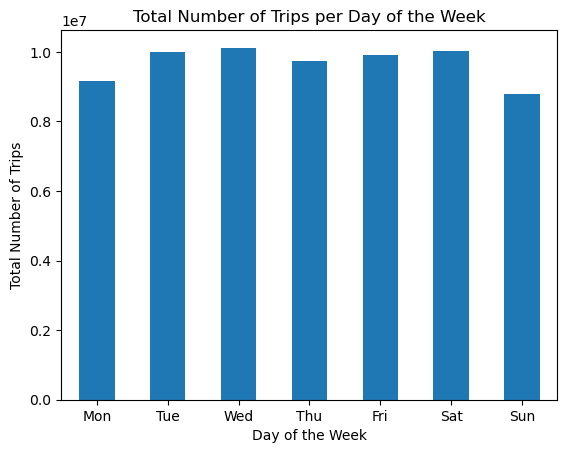

In [16]:
citibike.groupby('day_of_week')['num_of_trips'].sum().plot.bar()


plt.title('Total Number of Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Number of Trips')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation = 0)


plt.show()

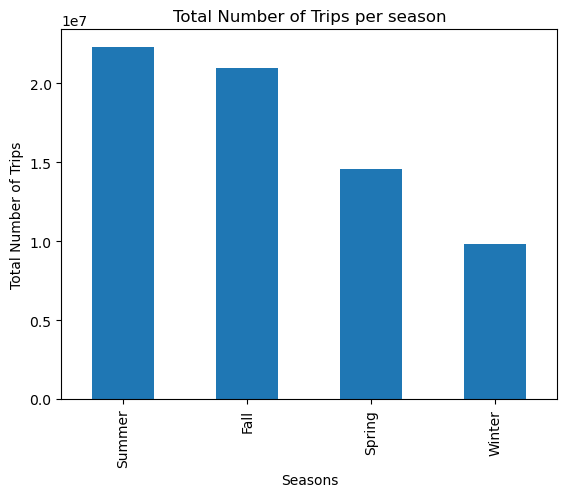

In [17]:
citibike.groupby('season')['num_of_trips'].sum().sort_values(ascending = False).plot.bar()


plt.title('Total Number of Trips per season')
plt.xlabel('Seasons')
plt.ylabel('Total Number of Trips')


plt.show()

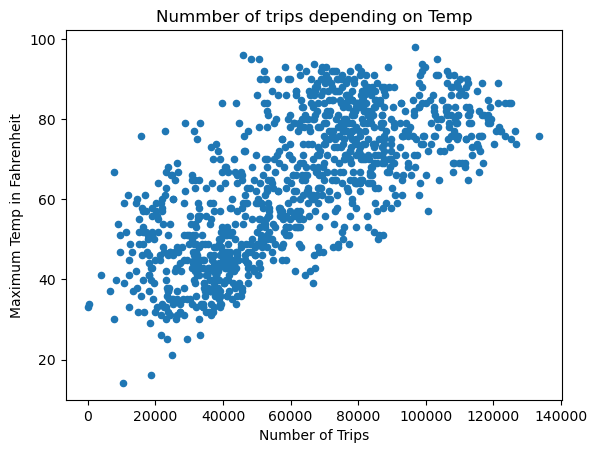

In [18]:
#plotting amount of trips against the max temp.
citibike.plot.scatter(x = 'num_of_trips', y = 'tmax')

plt.title('Nummber of trips depending on Temp')
plt.xlabel('Number of Trips')
plt.ylabel('Maximum Temp in Fahrenheit')

plt.show()

In [19]:
citibike['tmax'].describe()

count    1095.000000
mean       63.623616
std        17.404863
min        14.180000
25%        48.920000
50%        64.940000
75%        78.980000
max        98.060000
Name: tmax, dtype: float64

In [20]:
#is the tempertaure and num of trips correlated.
citibike[['num_of_trips', 'tmax']].corr()

,num_of_trips,tmax
num_of_trips,1.000000,0.705041
tmax,0.705041,1.000000


linear Regression Time 

In [21]:
#linear regression number of trips & tmax.

lm = smf.ols('num_of_trips ~ tmax', data = citibike).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_of_trips   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     1080.
Date:                Fri, 07 Jun 2024   Prob (F-statistic):          2.52e-165
Time:                        20:18:13   Log-Likelihood:                -12389.
No. Observations:                1095   AIC:                         2.478e+04
Df Residuals:                    1093   BIC:                         2.479e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.028e+04   2275.070     -4.521      0.000   -1.47e+04   -5820.870
tmax        1133.6926     34.492     32.868      0.000    1066.014    1201.371
==============================================================================
Omnibus:                        0.215   Durbin-Watson:                   0.661
Prob(Omnibus):                  0.898   Jarque-Bera (JB):                0.288
Skew:                           0.020   Prob(JB):                        0.866
Kurtosis:                       2.932   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

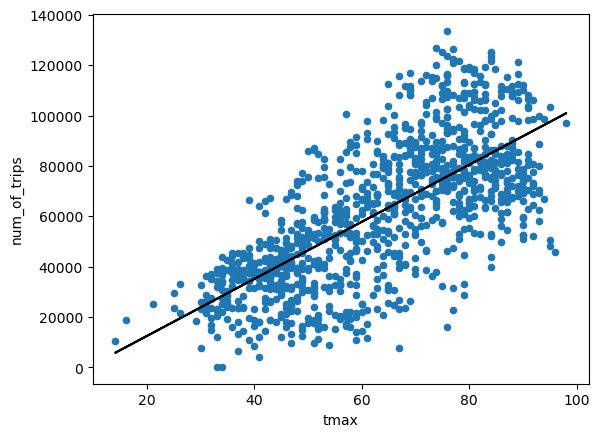

In [22]:
citibike.plot(x = 'tmax', y = 'num_of_trips', kind = 'scatter')
plt.plot(citibike['tmax'], lm.fittedvalues, color = 'black');

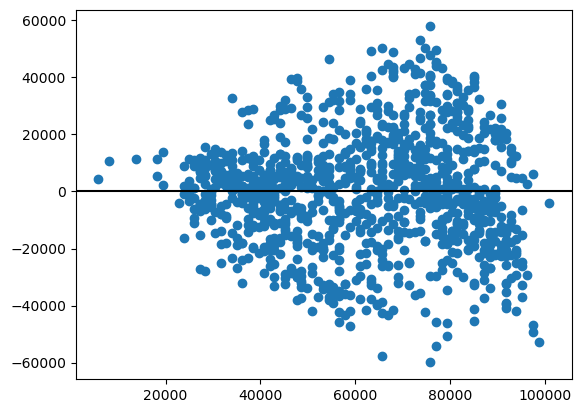

In [23]:
plt.scatter(lm.fittedvalues, lm.resid)
xmin, xmax = plt.xlim()
plt.hlines(y = 0, xmin = xmin, xmax = xmax, color = 'black')
plt.xlim(xmin, xmax);

In [24]:
lm_quad = smf.ols('num_of_trips ~ tmax + I(tmax**2)', data = citibike).fit()
lm_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_of_trips   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     551.0
Date:                Fri, 07 Jun 2024   Prob (F-statistic):          3.55e-166
Time:                        20:18:13   Log-Likelihood:                -12383.
No. Observations:                1095   AIC:                         2.477e+04
Df Residuals:                    1092   BIC:                         2.479e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -3.481e+04   7602.613     -4.579      0.000   -4.97e+04   -1.99e+04
tmax          1992.0563    256.298      7.772      0.000    1489.164    2494.949
I(tmax ** 2)    -6.9151      2.046     -3.380      0.001     -10.930      -2.900
==============================================================================
Omnibus:                        0.435   Durbin-Watson:                   0.684
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.508
Skew:                          -0.039   Prob(JB):                        0.776
Kurtosis:                       2.928   Cond. No.                     6.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

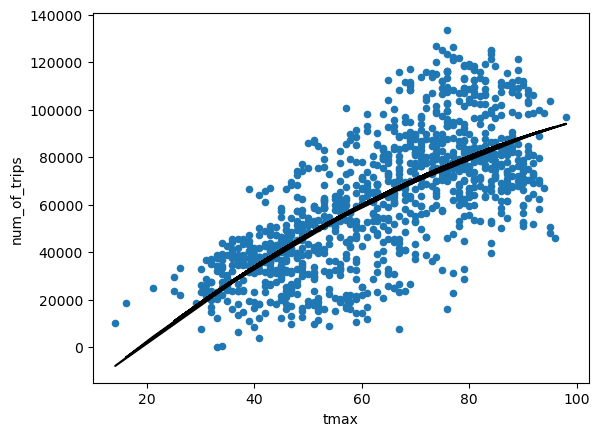

In [25]:
citibike.plot(x = 'tmax', y = 'num_of_trips', kind = 'scatter')
plt.plot(citibike['tmax'], lm_quad.fittedvalues, color = 'black');

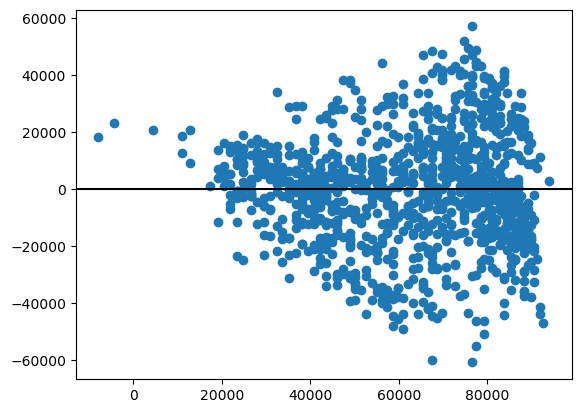

In [26]:
plt.scatter(lm_quad.fittedvalues, lm_quad.resid)
xmin, xmax = plt.xlim()
plt.hlines(y = 0, xmin = xmin, xmax = xmax, color = 'black')
plt.xlim(xmin, xmax);

In [27]:
#log linear regression number of trips & tmax.

lm_log = smf.ols('np.log(num_of_trips) ~ tmax', data = citibike).fit()
lm_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(num_of_trips)   R-squared:                       0.429
Model:                              OLS   Adj. R-squared:                  0.429
Method:                   Least Squares   F-statistic:                     822.6
Date:                  Fri, 07 Jun 2024   Prob (F-statistic):          2.46e-135
Time:                          20:18:14   Log-Likelihood:                -680.05
No. Observations:                  1095   AIC:                             1364.
Df Residuals:                      1093   BIC:                             1374.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4683      0.052    183.357      0.000       9.367       9.570
tmax           0.0225      0.001     28.681      0.000       0.021       0.024
==============================================================================
Omnibus:                      830.229   Durbin-Watson:                   0.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30947.779
Skew:                          -3.088   Prob(JB):                         0.00
Kurtosis:                      28.301   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

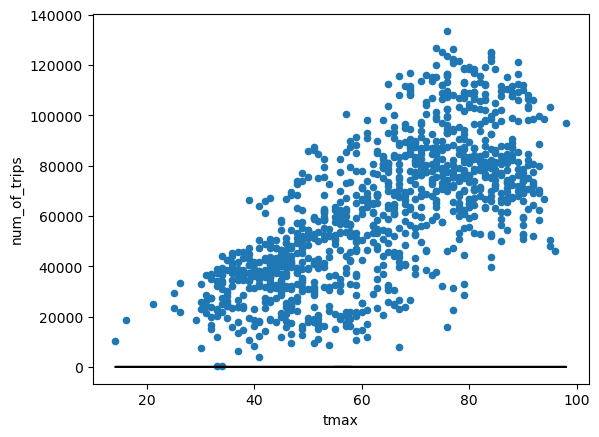

In [28]:
citibike.plot(x = 'tmax', y = 'num_of_trips', kind = 'scatter')
plt.plot(citibike['tmax'], lm_log.fittedvalues, color = 'black');

In [29]:
lm = smf.ols('num_of_trips ~ + season + day_of_week + tmax + I(tmax**2)', data = citibike).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_of_trips   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     136.3
Date:                Fri, 07 Jun 2024   Prob (F-statistic):          1.57e-195
Time:                        20:18:14   Log-Likelihood:                -12290.
No. Observations:                1095   AIC:                         2.460e+04
Df Residuals:                    1083   BIC:                         2.466e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -6262.8644   8810.875     -0.711      0.477   -2.36e+04     1.1e+04
season[T.Spring] -1.955e+04   1572.711    -12.430      0.000   -2.26e+04   -1.65e+04
season[T.Summer] -1.437e+04   2052.254     -7.004      0.000   -1.84e+04   -1.03e+04
season[T.Winter] -1.581e+04   2037.901     -7.758      0.000   -1.98e+04   -1.18e+04
day_of_week[T.1]  5179.9548   2063.974      2.510      0.012    1130.114    9229.796
day_of_week[T.2]  5882.6710   2059.586      2.856      0.004    1841.440    9923.902
day_of_week[T.3]  3383.8036   2059.807      1.643      0.101    -657.861    7425.468
day_of_week[T.4]  4407.0985   2059.677      2.140      0.033     365.689    8448.508
day_of_week[T.5]  5713.6723   2062.709      2.770      0.006    1666.313    9761.031
day_of_week[T.6] -2512.3367   2063.496     -1.218      0.224   -6561.239    1536.566
tmax              1388.0417    279.159      4.972      0.000     840.288    1935.795
I(tmax ** 2)        -2.5077      2.268     -1.106      0.269      -6.957       1.942
==============================================================================
Omnibus:                        1.492   Durbin-Watson:                   0.753
Prob(Omnibus):                  0.474   Jarque-Bera (JB):                1.425
Skew:                          -0.087   Prob(JB):                        0.490
Kurtosis:                       3.028   Cond. No.                     7.88e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
lm = smf.ols('num_of_trips ~ + season + day_of_week + tmax  + holiday + did_rain + awnd + rhav + rhmx + rhmn + tavg + event_happened + C(month) + C(year)', data = citibike).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_of_trips   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     131.6
Date:                Fri, 07 Jun 2024   Prob (F-statistic):          8.45e-301
Time:                        20:18:14   Log-Likelihood:                -10421.
No. Observations:                 961   AIC:                         2.090e+04
Df Residuals:                     932   BIC:                         2.104e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                2.11e+04   4218.626      5.001      0.000    1.28e+04    2.94e+04
season[T.Spring]       -5982.1284    828.010     -7.225      0.000   -7607.108   -4357.149
season[T.Summer]       -1353.7000   1521.830     -0.890      0.374   -4340.310    1632.910
season[T.Winter]       -6642.0943   1779.343     -3.733      0.000   -1.01e+04   -3150.111
day_of_week[T.1]        3715.6037   1544.248      2.406      0.016     684.997    6746.211
day_of_week[T.2]        4699.7317   1532.842      3.066      0.002    1691.510    7707.954
day_of_week[T.3]        3359.5596   1534.326      2.190      0.029     348.425    6370.694
day_of_week[T.4]        4659.9376   1525.236      3.055      0.002    1666.643    7653.233
day_of_week[T.5]        3785.8898   1549.332      2.444      0.015     745.307    6826.473
day_of_week[T.6]       -3671.6830   1549.335     -2.370      0.018   -6712.272    -631.094
holiday[T.True]        -1.111e+04   2495.072     -4.451      0.000    -1.6e+04   -6209.699
did_rain[T.True]       -8326.9648   1183.554     -7.036      0.000   -1.06e+04   -6004.225
event_happened[T.True]  4343.5962   5769.607      0.753      0.452   -6979.330    1.57e+04
C(month)[T.2]          -4760.4573   2378.255     -2.002      0.046   -9427.812     -93.103
C(month)[T.3]          -5905.3696   1227.746     -4.810      0.000   -8314.836   -3495.903
C(month)[T.4]          -4193.1802   1147.712     -3.654      0.000   -6445.580   -1940.780
C(month)[T.5]           4116.4214   1300.841      3.164      0.002    1563.505    6669.338
C(month)[T.6]           2147.1647   1258.329      1.706      0.088    -322.321    4616.651
C(month)[T.7]          -4765.0995   1251.855     -3.806      0.000   -7221.880   -2308.319
C(month)[T.8]           1264.2348   1227.493      1.030      0.303   -1144.735    3673.205
C(month)[T.9]           1.303e+04   1943.077      6.705      0.000    9215.613    1.68e+04
C(month)[T.10]          1.683e+04   1603.116     10.495      0.000    1.37e+04       2e+04
C(month)[T.11]          5219.7878   1304.481      4.001      0.000    2659.728    7779.848
C(month)[T.12]          4051.6078   2160.496      1.875      0.061    -188.393    8291.608
C(year)[T.2020]        -2089.7815   1051.472     -1.987      0.047   -4153.308     -26.255
C(year)[T.2021]         1.957e+04   1039.114     18.837      0.000    1.75e+04    2.16e+04
tmax                     217.7998    206.692      1.054      0.292    -187.836     623.436
awnd                    -342.0792     47.382     -7.220      0.000    -435.068    -249.090
rhav                    -539.3983     95.596     -5.642      0.000    -727.007    -351.789
rhmx                     196.9068     61.897      3.181      0.002      75.434     318.380
rhmn                      57.0516     65.848      0.866      0.386     -72.176  

In [111]:
lm.index

AttributeError: 'OLSResults' object has no attribute 'index'

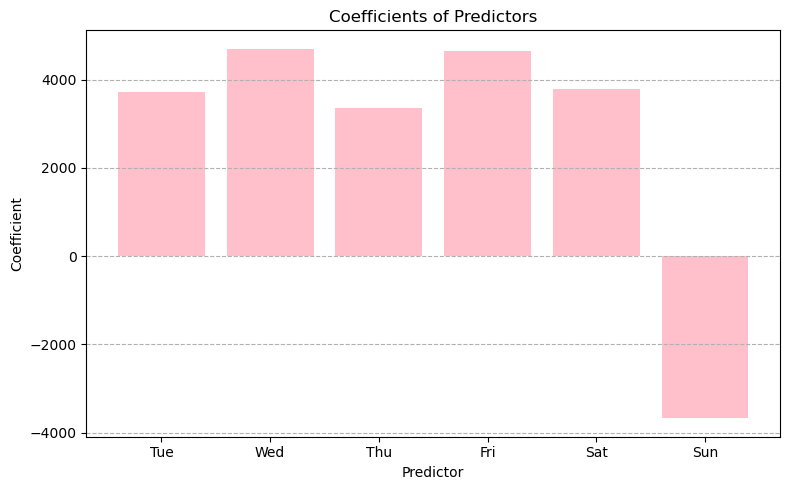

In [31]:
#Graphing day of the week coefficients when controling for season, max temp, a holiday, & rain
predictors = ['day_of_week[T.1]', 'day_of_week[T.2]', 'day_of_week[T.3]', 'day_of_week[T.4]', 'day_of_week[T.5]', 'day_of_week[T.6]']
coef = lm.params
coeffs = coef[predictors]

plt.figure(figsize=(8, 5))
plt.bar(predictors, coeffs, color=('pink'))
plt.xlabel('Predictor')
plt.ylabel('Coefficient')
plt.title('Coefficients of Predictors')
plt.xticks(ticks=range(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.grid(axis='y',linestyle='--')
plt.tight_layout()
plt.show()

In [32]:
coeffs

day_of_week[T.1]    3715.603703
day_of_week[T.2]    4699.731666
day_of_week[T.3]    3359.559576
day_of_week[T.4]    4659.937576
day_of_week[T.5]    3785.889760
day_of_week[T.6]   -3671.682975
dtype: float64

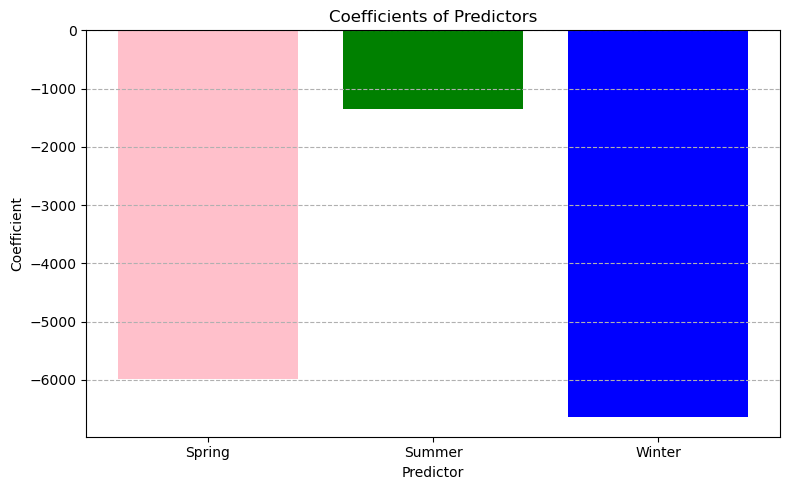

In [33]:
#Graphing the season coefficients when controling for day of week, max temp, a holiday, & rain

predictors = ['season[T.Spring]', 'season[T.Summer]', 'season[T.Winter]']
coef = lm.params
coeffs = coef[predictors]

plt.figure(figsize=(8, 5))
plt.bar(predictors, coeffs, color=['pink', 'green', 'blue'])
plt.xlabel('Predictor')
plt.ylabel('Coefficient')
plt.title('Coefficients of Predictors')
plt.xticks(ticks=range(3), labels=['Spring', 'Summer', 'Winter'], rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

***Full & Reduced Models***

In [100]:
#Adding Season
lr_reduced = smf.ols('num_of_trips ~ + tmax', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1093.0,4.309407e+11,0.0,NaN,NaN,NaN
1,1090.0,3.694042e+11,3.0,6.153652e+10,60.525224,3.401060e-36


In [101]:
#Addu=ing year as a catergory
lr_reduced = smf.ols('num_of_trips ~ + tmax + season', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year)', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1090.0,3.694042e+11,0.0,NaN,NaN,NaN
1,1088.0,2.609192e+11,2.0,1.084849e+11,226.184197,7.216677e-83


In [36]:
#Adding day of week
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year)', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1088.0,2.609192e+11,0.0,NaN,NaN,NaN
1,1082.0,2.512135e+11,6.0,9.705698e+09,6.967224,2.777874e-07


In [37]:
#adding holiday
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1082.0,2.512135e+11,0.0,NaN,NaN,NaN
1,1081.0,2.471952e+11,1.0,4.018336e+09,17.572436,0.00003


In [38]:
#adding prcp
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1081.0,2.471952e+11,0.0,NaN,NaN,NaN
1,1080.0,1.980662e+11,1.0,4.912904e+10,267.887072,5.892625e-54


In [39]:
#adding snow
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1080.0,1.980662e+11,0.0,NaN,NaN,NaN
1,1079.0,1.978379e+11,1.0,2.282573e+08,1.244906,0.264776


In [102]:
#Adding Month
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month)', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1079.0,1.978379e+11,0.0,NaN,NaN,NaN
1,1071.0,1.866586e+11,8.0,1.117931e+10,8.018011,1.523662e-10


In [103]:
#adding wind
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month)', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1071.0,1.866586e+11,0.0,NaN,NaN,NaN
1,947.0,1.610642e+11,124.0,2.559437e+10,1.213595,0.06645


In [104]:
#adding avg humidity 
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,947.0,1.610642e+11,0.0,NaN,NaN,NaN
1,935.0,1.429656e+11,12.0,1.809860e+10,9.863786,2.360959e-18


In [105]:
#adding min humidity 
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,935.0,1.429656e+11,0.0,NaN,NaN,NaN
1,934.0,1.428437e+11,1.0,1.218756e+08,0.796897,0.372253


In [44]:
#adding max humidity 
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav + rhmn', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn + rhmx', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,934.0,1.428437e+11,0.0,NaN,NaN,NaN
1,933.0,1.428155e+11,1.0,2.821491e+07,0.184325,0.667781


In [106]:
#adding avg temp
lr_reduced = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav + rhmn + rhmx', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn + rhmx + tavg', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,933.0,1.428155e+11,0.0,NaN,NaN,NaN
1,932.0,1.411673e+11,1.0,1.648223e+09,10.881723,0.001008


In [107]:
#adding event happened
lr_reduced = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav + rhmn + rhmx + tavg', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened ', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,932.0,1.411673e+11,0.0,NaN,NaN,NaN
1,931.0,1.411499e+11,1.0,1.742506e+07,0.114933,0.734673


In [108]:
#adding if it rained
lr_reduced = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened + did_rain ', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,931.0,1.411499e+11,0.0,NaN,NaN,NaN
1,930.0,1.374386e+11,1.0,3.711296e+09,25.113075,6.470573e-07


In [88]:
#adding if snowed
lr_reduced = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened + did_rain', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened + did_rain + is_snow', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,930.0,1.374386e+11,0.0,NaN,NaN,NaN
1,929.0,1.373542e+11,1.0,8.442330e+07,0.571,0.450053


In [109]:
#adding min temp
lr_reduced = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened + did_rain + is_snow', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened + did_rain + is_snow + tmin', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,929.0,1.373542e+11,0.0,NaN,NaN,NaN
1,929.0,1.373542e+11,-0.0,0.000015,-inf,NaN


In [47]:
citibike.head(1)

,date,num_of_trips,holiday,prcp,snow,awnd,rhav,rhmn,rhmx,tmax,tmin,tavg,median_trip_duration,mean_trip_duration,day_of_week,year,month,is_snow,did_rain,season,event_happened
0,2019-01-01,21962,True,15,0.0,NaN,69.0,47.0,97.0,57.92,39.02,48.47,663.0,1175.93,1,2019,1,False,True,Winter,False


***correlations***

In [48]:
citibike.select_dtypes(include=['number']).corr()

,num_of_trips,prcp,snow,awnd,rhav,rhmn,rhmx,tmax,tmin,tavg,median_trip_duration,mean_trip_duration,year,month
num_of_trips,1.000000,-0.186466,-0.159269,-0.467975,-0.013708,0.011330,0.028304,0.705041,0.689437,0.705408,0.278038,0.193989,0.286941,0.347719
prcp,-0.186466,1.000000,0.151840,0.097745,0.403763,0.307399,0.350660,0.056548,0.087003,0.071896,-0.142284,-0.059818,0.018265,0.033162
snow,-0.159269,0.151840,1.000000,0.172752,0.079586,0.059393,0.076247,-0.151351,-0.143582,-0.149294,-0.085638,0.104679,0.022205,-0.056983
awnd,-0.467975,0.097745,0.172752,1.000000,-0.223436,-0.165424,-0.200322,-0.503938,-0.509769,-0.512876,-0.241825,-0.156699,0.062445,-0.147743
rhav,-0.013708,0.403763,0.079586,-0.223436,1.000000,0.875197,0.847178,0.219053,0.340240,0.280028,-0.065102,0.009010,-0.004495,0.204702
rhmn,0.011330,0.307399,0.059393,-0.165424,0.875197,1.000000,0.617281,0.128835,0.278966,0.202779,-0.120000,-0.037753,0.049342,0.227756
rhmx,0.028304,0.350660,0.076247,-0.200322,0.847178,0.617281,1.000000,0.285222,0.352433,0.320870,0.015898,0.076108,-0.036797,0.161161
tmax,0.705041,0.056548,-0.151351,-0.503938,0.219053,0.128835,0.285222,1.000000,0.955806,0.989861,0.537095,0.446741,0.029237,0.248213
tmin,0.689437,0.087003,-0.143582,-0.509769,0.340240,0.278966,0.352433,0.955806,1.000000,0.987874,0.480692,0.405397,0.037367,0.299236
tavg,0.705408,0.071896,-0.149294,-0.512876,0.280028,0.202779,0.320870,0.989861,0.987874,1.000000,0.515868,0.431776,0.033493,0.275646


**linear regression: Median Trip Duration.**

In [49]:
lm = smf.ols('median_trip_duration ~ tmax', data = citibike).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     median_trip_duration   R-squared:                       0.288
Model:                              OLS   Adj. R-squared:                  0.288
Method:                   Least Squares   F-statistic:                     443.1
Date:                  Fri, 07 Jun 2024   Prob (F-statistic):           7.50e-83
Time:                          20:18:15   Log-Likelihood:                -6905.4
No. Observations:                  1095   AIC:                         1.381e+04
Df Residuals:                      1093   BIC:                         1.382e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    364.4330     15.207     23.964      0.000     334.594     394.272
tmax           4.8534      0.231     21.051      0.000       4.401       5.306
==============================================================================
Omnibus:                      401.195   Durbin-Watson:                   0.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1498.345
Skew:                           1.755   Prob(JB):                         0.00
Kurtosis:                       7.530   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

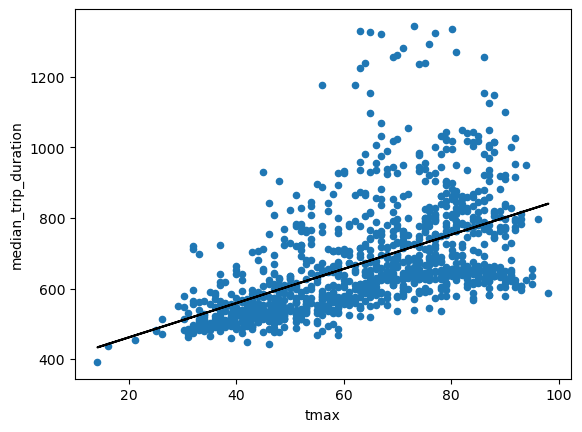

In [50]:
citibike.plot(x = 'tmax', y = 'median_trip_duration', kind = 'scatter')
plt.plot(citibike['tmax'], lm.fittedvalues, color = 'black');

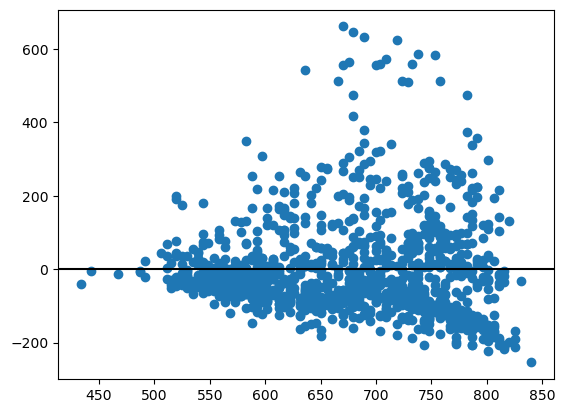

In [51]:
plt.scatter(lm.fittedvalues, lm.resid)
xmin, xmax = plt.xlim()
plt.hlines(y = 0, xmin = xmin, xmax = xmax, color = 'black')
plt.xlim(xmin, xmax);

In [52]:
citibike.columns

Index(['date', 'num_of_trips', 'holiday', 'prcp', 'snow', 'awnd', 'rhav',
       'rhmn', 'rhmx', 'tmax', 'tmin', 'tavg', 'median_trip_duration',
       'mean_trip_duration', 'day_of_week', 'year', 'month', 'is_snow',
       'did_rain', 'season', 'event_happened'],
      dtype='object')

In [53]:
citibike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 0 to 1094
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1095 non-null   datetime64[ns]
 1   num_of_trips          1095 non-null   int64         
 2   holiday               1095 non-null   bool          
 3   prcp                  1095 non-null   int64         
 4   snow                  1095 non-null   float64       
 5   awnd                  972 non-null    float64       
 6   rhav                  1084 non-null   float64       
 7   rhmn                  1084 non-null   float64       
 8   rhmx                  1084 non-null   float64       
 9   tmax                  1095 non-null   float64       
 10  tmin                  1095 non-null   float64       
 11  tavg                  1095 non-null   float64       
 12  median_trip_duration  1095 non-null   float64       
 13  mean_trip_duration

In [79]:
citibike.columns

Index(['date', 'num_of_trips', 'holiday', 'prcp', 'snow', 'awnd', 'rhav',
       'rhmn', 'rhmx', 'tmax', 'tmin', 'tavg', 'median_trip_duration',
       'mean_trip_duration', 'day_of_week', 'year', 'month', 'is_snow',
       'did_rain', 'season', 'event_happened'],
      dtype='object')

In [84]:
#using all statistically significant features.

lm_med_len = smf.ols('median_trip_duration ~ tmax + tavg + awnd + season + year + C(month) + holiday + did_rain + is_snow + day_of_week + rhav', data = citibike).fit()
lm_med_len.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     median_trip_duration   R-squared:                       0.477
Model:                              OLS   Adj. R-squared:                  0.463
Method:                   Least Squares   F-statistic:                     34.10
Date:                  Fri, 07 Jun 2024   Prob (F-statistic):          2.36e-113
Time:                          20:45:01   Log-Likelihood:                -5824.6
No. Observations:                   961   AIC:                         1.170e+04
Df Residuals:                       935   BIC:                         1.183e+04
Df Model:                            25                                         
Covariance Type:              nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -2.146e+04   7357.191     -2.917      0.004   -3.59e+04   -7020.190
season[T.Spring] -2891.0992   1003.138     -2.882      0.004   -4859.762    -922.436
season[T.Summer] -2919.9480   1002.847     -2.912      0.004   -4888.040    -951.856
season[T.Winter] -3953.2751   1340.010     -2.950      0.003   -6583.051   -1323.499
C(month)[T.2]       -9.5718     19.897     -0.481      0.631     -48.620      29.476
C(month)[T.3]    -1002.6018    335.016     -2.993      0.003   -1660.071    -345.132
C(month)[T.4]     -935.1720    334.243     -2.798      0.005   -1591.125    -279.219
C(month)[T.5]     -953.3254    334.325     -2.851      0.004   -1609.439    -297.212
C(month)[T.6]     -970.7271    334.471     -2.902      0.004   -1627.128    -314.326
C(month)[T.7]     -974.9182    334.393     -2.915      0.004   -1631.167    -318.670
C(month)[T.8]     -974.3027    334.385     -2.914      0.004   -1630.535    -318.071
C(month)[T.9]    -3871.7417   1336.508     -2.897      0.004   -6494.645   -1248.838
C(month)[T.10]   -3896.2243   1337.402     -2.913      0.004   -6520.882   -1271.567
C(month)[T.11]   -3926.4218   1337.595     -2.935      0.003   -6551.457   -1301.386
C(month)[T.12]      14.5754     18.029      0.808      0.419     -20.806      49.957
holiday[T.True]     67.9619     20.856      3.259      0.001      27.031     108.893
did_rain[T.True]   -36.7232      9.336     -3.934      0.000     -55.045     -18.401
is_snow[T.True]     61.4592     26.924      2.283      0.023       8.622     114.297
day_of_week[T.1]     9.8698     12.870      0.767      0.443     -15.388      35.128
day_of_week[T.2]     5.2569     12.784      0.411      0.681     -19.831      30.345
day_of_week[T.3]     9.3794     12.793      0.733      0.464     -15.728      34.487
day_of_week[T.4]    22.7595     12.762      1.783      0.075      -2.286      47.805
day_of_week[T.5]   139.8143     12.938     10.806      0.000     114.423     165.205
day_of_week[T.6]   116.1492     12.879      9.018      0.000      90.874     141.424
tmax                 5.0640      1.673      3.026      0.003       1.780       8.348
tavg                -1.8156      1.986     -0.914      0.361      -5.713       2.082
awnd                -0.3060      0.393     -0.778      0.437      -1.078       0.466
year                12.7810      4.304      2.969      0.003       4.334      21.229
rhav                -0.5956      0.335     -1.777      0.076      -1.253       0.062
==============================================================================
Omnibus:                      240.335   Durbin-Watson:                   0.434
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              595.869
Skew:                           1.313   Prob(JB):                    4.06e-130
Kurtosis:                

In [81]:
#using all features even the ones that are not statistically significant

lm_med_len = smf.ols('median_trip_duration ~ tmax + tmin + tavg+ prcp + snow + awnd + season + year + C(month) + holiday + did_rain + is_snow + day_of_week + rhav + rhmn + rhmx + event_happened', data = citibike).fit()
lm_med_len.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     median_trip_duration   R-squared:                       0.493
Model:                              OLS   Adj. R-squared:                  0.476
Method:                   Least Squares   F-statistic:                     30.09
Date:                  Fri, 07 Jun 2024   Prob (F-statistic):          1.69e-115
Time:                          20:28:21   Log-Likelihood:                -5810.1
No. Observations:                   961   AIC:                         1.168e+04
Df Residuals:                       930   BIC:                         1.183e+04
Df Model:                            30                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -2.531e+04   7331.894     -3.452      0.001   -3.97e+04   -1.09e+04
season[T.Spring]       -3418.2425    999.761     -3.419      0.001   -5380.291   -1456.194
season[T.Summer]       -3442.6634    999.346     -3.445      0.001   -5403.898   -1481.429
season[T.Winter]       -4657.5207   1335.463     -3.488      0.001   -7278.392   -2036.650
C(month)[T.2]            -12.1152     19.779     -0.613      0.540     -50.931      26.701
C(month)[T.3]          -1177.4348    333.921     -3.526      0.000   -1832.762    -522.108
C(month)[T.4]          -1112.8273    333.161     -3.340      0.001   -1766.661    -458.993
C(month)[T.5]          -1127.9804    333.116     -3.386      0.001   -1781.727    -474.234
C(month)[T.6]          -1146.8502    333.396     -3.440      0.001   -1801.146    -492.554
C(month)[T.7]          -1147.5440    333.176     -3.444      0.001   -1801.407    -493.681
C(month)[T.8]          -1148.2691    333.172     -3.446      0.001   -1802.124    -494.414
C(month)[T.9]          -4569.3721   1331.836     -3.431      0.001   -7183.125   -1955.620
C(month)[T.10]         -4597.3958   1332.751     -3.450      0.001   -7212.943   -1981.848
C(month)[T.11]         -4628.1654   1333.042     -3.472      0.001   -7244.285   -2012.046
C(month)[T.12]            15.0352     17.825      0.843      0.399     -19.947      50.018
holiday[T.True]           69.4874     20.619      3.370      0.001      29.022     109.952
did_rain[T.True]         -37.7116     10.120     -3.726      0.000     -57.573     -17.850
is_snow[T.True]           34.9438     31.729      1.101      0.271     -27.326      97.213
day_of_week[T.1]          11.4121     12.773      0.893      0.372     -13.654      36.478
day_of_week[T.2]           7.0932     12.672      0.560      0.576     -17.776      31.962
day_of_week[T.3]          12.2893     12.678      0.969      0.333     -12.592      37.171
day_of_week[T.4]          21.8844     12.628      1.733      0.083      -2.898      46.667
day_of_week[T.5]         142.0713     12.814     11.087      0.000     116.924     167.219
day_of_week[T.6]         118.3558     12.822      9.231      0.000      93.193     143.519
event_happened[T.True]   -34.1309     47.631     -0.717      0.474    -127.608      59.346
tmax                       3.0010      0.805      3.726      0.000       1.420       4.582
tmin                      -0.9518      0.947     -1.005      0.315      -2.811       0.907
tavg                       1.0246      0.195      5.251      0.000       0.642       1.408
prcp                      -0.1399      0.037     -3.833      0.000      -0.212      -0.068
snow                       0.2518      0.285      0.884      0.377      -0.307       0.811
awnd                      -0.0290      0.401     -0.072   

In [112]:
coef.keys()

Index(['Intercept', 'season[T.Spring]', 'season[T.Summer]', 'season[T.Winter]',
       'C(year)[T.2020]', 'C(year)[T.2021]', 'C(month)[T.2]', 'C(month)[T.3]',
       'C(month)[T.4]', 'C(month)[T.5]', 'C(month)[T.6]', 'C(month)[T.7]',
       'C(month)[T.8]', 'C(month)[T.9]', 'C(month)[T.10]', 'C(month)[T.11]',
       'C(month)[T.12]', 'holiday[T.True]', 'did_rain[T.True]',
       'is_snow[T.True]', 'day_of_week[T.1]', 'day_of_week[T.2]',
       'day_of_week[T.3]', 'day_of_week[T.4]', 'day_of_week[T.5]',
       'day_of_week[T.6]', 'tmax'],
      dtype='object')

In [56]:
coeffs

season[T.Spring]   -5982.128362
season[T.Summer]   -1353.699967
season[T.Winter]   -6642.094323
dtype: float64

In [57]:
predictors

['season[T.Spring]', 'season[T.Summer]', 'season[T.Winter]']

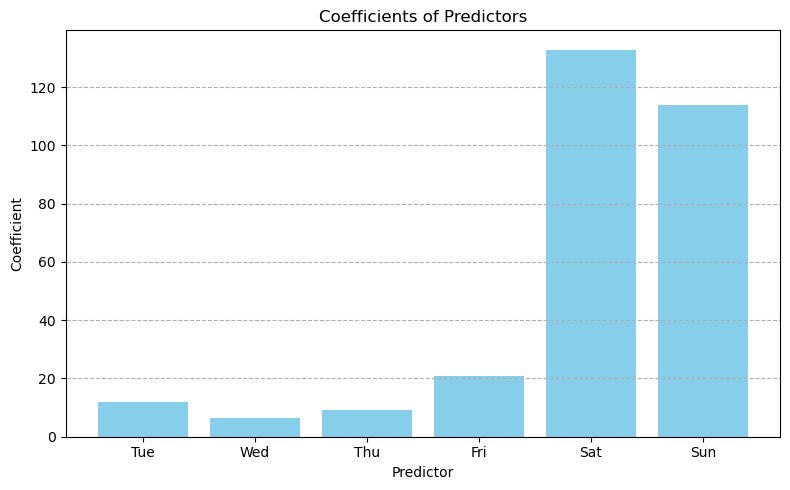

In [58]:
#Graphing day of the week coefficients when controling for season, max temp, a holiday, & rain
predictors = ['day_of_week[T.1]', 'day_of_week[T.2]', 'day_of_week[T.3]', 'day_of_week[T.4]', 'day_of_week[T.5]', 'day_of_week[T.6]']
coef = lm_med_len.params
coeffs = coef[predictors]

plt.figure(figsize=(8, 5))
plt.bar(predictors, coeffs, color=('skyblue'))
plt.xlabel('Predictor')
plt.ylabel('Coefficient')
plt.title('Coefficients of Predictors')
plt.xticks(ticks=range(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.grid(axis='y',linestyle='--')
plt.tight_layout()
plt.show()

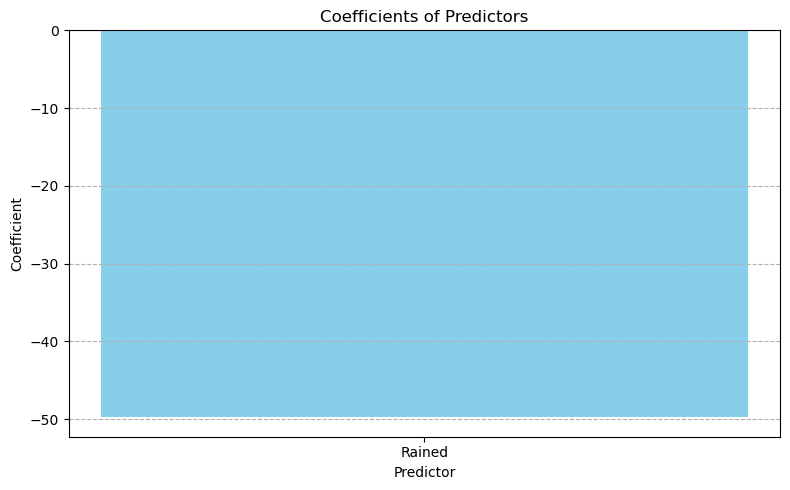

In [59]:
predictors = ['did_rain[T.True]']
coef = lm_med_len.params
coeffs = coef[predictors]

plt.figure(figsize=(8, 5))
plt.bar(predictors, coeffs, color=('skyblue'))
plt.xlabel('Predictor')
plt.ylabel('Coefficient')
plt.title('Coefficients of Predictors')
plt.xticks(ticks=range(1), labels=['Rained'], rotation=0)
plt.grid(axis='y',linestyle='--')
plt.tight_layout()
plt.show()

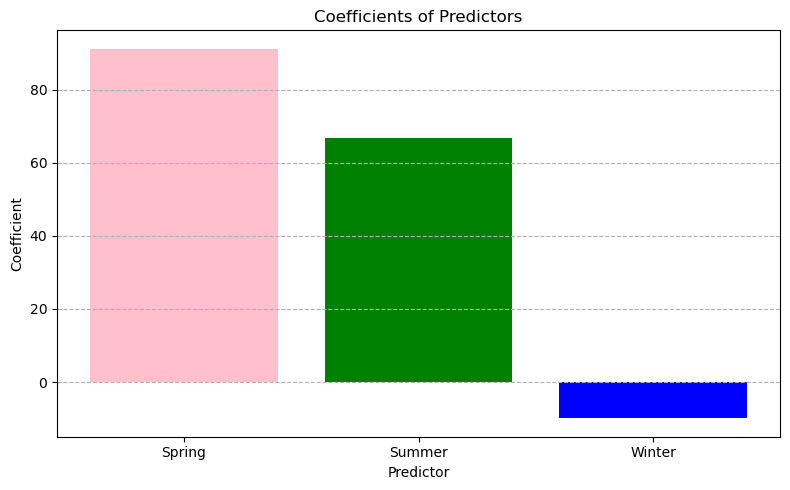

In [60]:
predictors = ['season[T.Spring]', 'season[T.Summer]', 'season[T.Winter]']
coef = lm_med_len.params
coeffs = coef[predictors]

plt.figure(figsize=(8, 5))
plt.bar(predictors, coeffs, color=['pink', 'green', 'blue'])
plt.xlabel('Predictor')
plt.ylabel('Coefficient')
plt.title('Coefficients of Predictors')
plt.xticks(ticks=range(3), labels=['Spring', 'Summer', 'Winter'], rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
lm = smf.ols('median_trip_duration ~ tmax', data = citibike).fit()
lm.summary()

In [61]:
#Adding Season
lr_reduced = smf.ols('median_trip_duration ~ + tmax', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1093.0,1.925458e+07,0.0,NaN,NaN,NaN
1,1090.0,1.813586e+07,3.0,1.118723e+06,22.412478,4.380756e-14


In [83]:
#Adding year as numerical
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + year', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1090.0,1.813586e+07,0.0,NaN,NaN,NaN
1,1089.0,1.799642e+07,1.0,139436.005386,8.437557,0.00375


In [86]:
#Adding year as catergorical 
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year)', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1090.0,1.813586e+07,0.0,NaN,NaN,NaN
1,1088.0,1.206539e+07,2.0,6.070464e+06,273.702921,5.173954e-97


In [63]:
##Adding day of week
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year)', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1088.0,1.206539e+07,0.0,NaN,NaN,NaN
1,1082.0,9.235423e+06,6.0,2.829967e+06,55.258694,1.293368e-59


In [64]:
#Adding Holiday
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1082.0,9.235423e+06,0.0,NaN,NaN,NaN
1,1081.0,9.053738e+06,1.0,181685.323574,21.6929,0.000004


In [65]:
##Adding if it rained
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1081.0,9.053738e+06,0.0,NaN,NaN,NaN
1,1080.0,8.604887e+06,1.0,448851.291417,56.33536,1.274723e-13


In [66]:
#Adding if it snowed
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1080.0,8.604887e+06,0.0,NaN,NaN,NaN
1,1079.0,8.490156e+06,1.0,114730.458095,14.580905,0.000142


In [67]:
#adding Month
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month)', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1079.0,8.490156e+06,0.0,NaN,NaN,NaN
1,1071.0,7.626081e+06,8.0,864075.246437,15.168744,3.130054e-21


In [90]:
#adding prcp
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month)', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1071.0,7.626081e+06,0.0,NaN,NaN,NaN
1,1070.0,7.421390e+06,1.0,204690.90277,29.511892,6.878428e-08


In [92]:
#Adding snow
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow ', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1070.0,7.421390e+06,0.0,NaN,NaN,NaN
1,1069.0,7.421154e+06,1.0,236.155878,0.034018,0.853704


In [93]:
#Adding Wind 
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1069.0,7.421154e+06,0.0,NaN,NaN,NaN
1,945.0,5.724694e+06,124.0,1.696460e+06,2.258403,9.707244e-12


In [94]:
#Adding avg humidity
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav ', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,945.0,5.724694e+06,0.0,NaN,NaN,NaN
1,933.0,5.615512e+06,12.0,109181.557971,1.511681,0.113818


In [95]:
#Adding min humidity
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,933.0,5.615512e+06,0.0,NaN,NaN,NaN
1,932.0,5.599871e+06,1.0,15641.659939,2.603279,0.106981


In [96]:
#Adding max humidity
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,932.0,5.599871e+06,0.0,NaN,NaN,NaN
1,931.0,5.581837e+06,1.0,18033.93506,3.007898,0.083191


In [97]:
#Adding min temp
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx + tmin', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,931.0,5.581837e+06,0.0,NaN,NaN,NaN
1,930.0,5.579033e+06,1.0,2803.408821,0.467316,0.494395


In [98]:
#Adding avg temp
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx + tmin', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx + tmin + tavg', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,930.0,5.579033e+06,0.0,NaN,NaN,NaN
1,930.0,5.579033e+06,-0.0,3.725290e-09,-inf,NaN


In [99]:
#Adding event
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx + tmin + tavg', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx + tmin + tavg + event_happened', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,930.0,5.579033e+06,0.0,NaN,NaN,NaN
1,929.0,5.579033e+06,1.0,0.032179,0.000005,0.998154


In [91]:
citibike.columns

Index(['date', 'num_of_trips', 'holiday', 'prcp', 'snow', 'awnd', 'rhav',
       'rhmn', 'rhmx', 'tmax', 'tmin', 'tavg', 'median_trip_duration',
       'mean_trip_duration', 'day_of_week', 'year', 'month', 'is_snow',
       'did_rain', 'season', 'event_happened'],
      dtype='object')

In [75]:
 #citibike.to_csv('../data/citibike_vis.csv')

In [76]:
#citibike['is_snow'] = citibike['snow'] != 0

In [77]:
#citibike['did_rain'] = citibike['prcp'] != 0